In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

/Users/javiers/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
#We read the data using pandas
data_table = pd.read_csv('/Users/javiers/Documents/LSST_clustering/test_80sq_degree_galaxy_catalog.txt')

In [4]:
#Let's check how it read the headers
data_table.keys()

Index([u'#raJ2000', u' decJ2000', u' redshift', u' u_ab', u' g_ab', u' r_ab',
       u' i_ab', u' z_ab', u' y_ab'],
      dtype='object')

In [6]:
#Subsampling the input data (If you want to plot using pairplot set frac to 0.01 or less)

#Taking a random 25% of the sample
new_table = data_table.sample(frac=0.25)

In [8]:
#Selecting the gold sample (comment out the line below if you want to plot and compare the gold sample with the total)
#gold = new_table[' r_ab']<25.3

In [9]:
#Creating a column to use as hue in pairplot
#new_table['gold'] = pd.Series(np.empty_like(new_table[' r_ab']), index=new_table.index)

In [10]:
#Comment out if you want to use pairplot

#new_table['gold'][gold]='GOLD'
#new_table['gold'][~gold]='TOTAL'

/Users/javiers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [7]:
#If you want to save the subsample
new_table.to_hdf('test_catsim_25percent.hdf5','data')

In [8]:
#Clean everything up (to free up some memory)
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

/Users/javiers/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
new_table = pd.read_hdf('/Users/javiers/Documents/LSST_clustering/test_catsim_25percent.hdf5','data')

In [4]:
#From @slosar

#circle coordinates, in degress, see issue #3
cent_ra=120
cent_dec=-10
radius=5.16

# Cosmology
omega_matter = 0.25
Omega_baryon = 0.045
Omega_curvature = 0
H0 = 73
sigma_8 = 0.9
n_s = 1
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=H0,Om0=omega_matter)

In [12]:
#This plot is better to do with frac=0.01 or less, if not, it can be too much to handle, see issue #4 for the results
#sns.pairplot(new_table,hue='gold')

In [5]:
print len(new_table)

17947273


In [6]:
#Creating 3D coordinates for the catalog:
r=cosmo.comoving_distance(new_table[' redshift'])
x=r*np.cos(new_table['#raJ2000']*np.pi/180.)*np.cos(new_table[' decJ2000']*np.pi/180.)
y=r*np.sin(new_table['#raJ2000']*np.pi/180.)*np.cos(new_table[' decJ2000']*np.pi/180.)
z=r*np.sin(new_table[' decJ2000']*np.pi/180.)

In [7]:
#Generating uniform random in the circle
def generate_rnd(factor=10):
    #Creating random that follows N(z)
    r_rnd = np.random.choice(r,size=factor*len(new_table))
    ra_rnd = cent_ra-radius+2*radius*np.random.random(size=factor*len(new_table))
    cth_rnd = np.sin(cent_dec-radius)+(np.sin(cent_dec+radius)-np.sin(cent_dec-radius))*np.random.random(size=factor*len(new_table))
    dec_rnd = np.arcsin(cth_rnd)*180/np.pi
    myrand = (ra_rnd-cent_ra)**2+(dec_rnd-cent_dec)**2<=radius**2
    ra_rnd = ra_rnd[myrand]
    dec_rnd = dec_rnd[myrand]
    r_rnd = r_rnd[myrand]
    xrand=r_rnd*np.cos(ra_rnd*np.pi/180.)*np.cos(dec_rnd*np.pi/180.)
    yrand=r_rnd*np.sin(ra_rnd*np.pi/180.)*np.cos(dec_rnd*np.pi/180.)
    zrand=r_rnd*np.sin(dec_rnd*np.pi/180.)
    return xrand, yrand, zrand

In [9]:
xrand, yrand, zrand = generate_rnd(factor=11)
print len(xrand)

18171994


In [19]:
#Plotting the random

#plt.hist2d(ra_rnd,dec_rnd,bins=128);
#plt.colorbar()

In [20]:
#Plotting the data

#plt.hist2d(new_table['#raJ2000'],new_table[' decJ2000'],bins=128);
#plt.colorbar()

## Correlations

In [10]:
import treecorr as tc

In [14]:
xires=[]
for zmin,zmax in [(0,0.5),(0.5,1.0), (1.0,1.5),(1.5,3.0)]:
    print "Doing",zmin,"-",zmax
    dimin,dimax=cosmo.comoving_distance([zmin,zmax])
    wh=np.where((r>dimin)&(r<dimax))
    sigcat=tc.Catalog(x=x[wh],y=y[wh],z=z[wh])
    whr=np.where((xrand**2+yrand**2+zrand**2>dimin.value**2)&(xrand**2+yrand**2+zrand**2<dimax.value**2))
    rancat=tc.Catalog(x=xrand[whr],y=yrand[whr],z=zrand[whr])
    dd=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    dd.process(sigcat)
    dr=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    dr.process(sigcat,rancat)
    rr=tc.NNCorrelation(min_sep=0.1,bin_size=0.1,max_sep=200.)
    rr.process(rancat,rancat)
    xi,xivar=dd.calculateXi(rr,dr)
    xires.append((zmin,zmax,np.exp(dd.logr),xi,xivar))

Doing 0 - 0.5
Doing 0.5 - 1.0
Doing 1.0 - 1.5
Doing 1.5 - 3.0


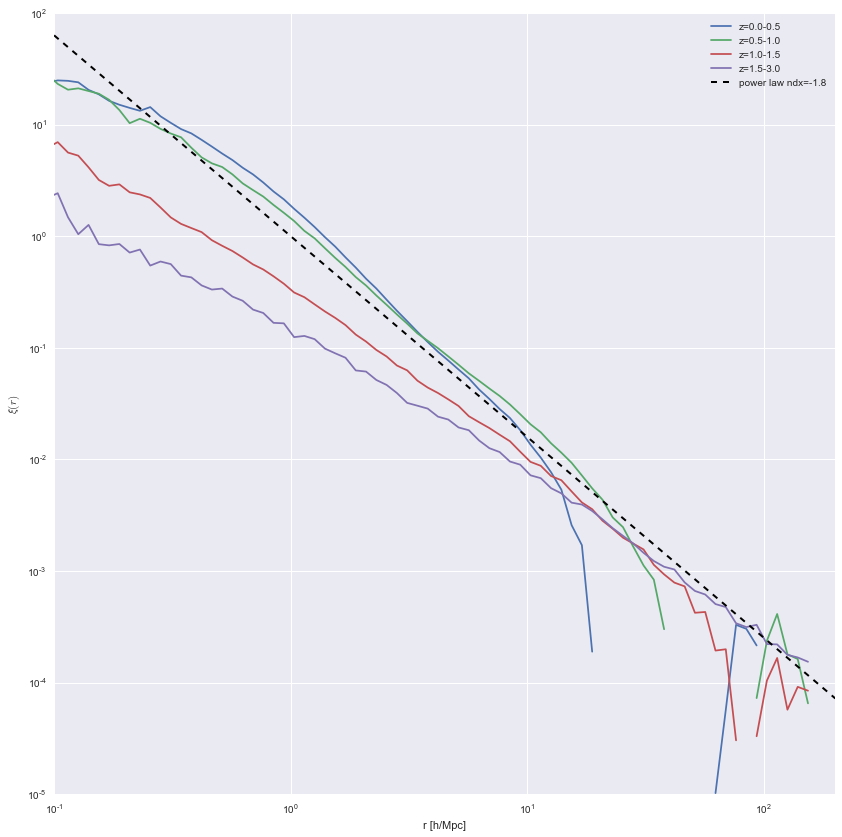

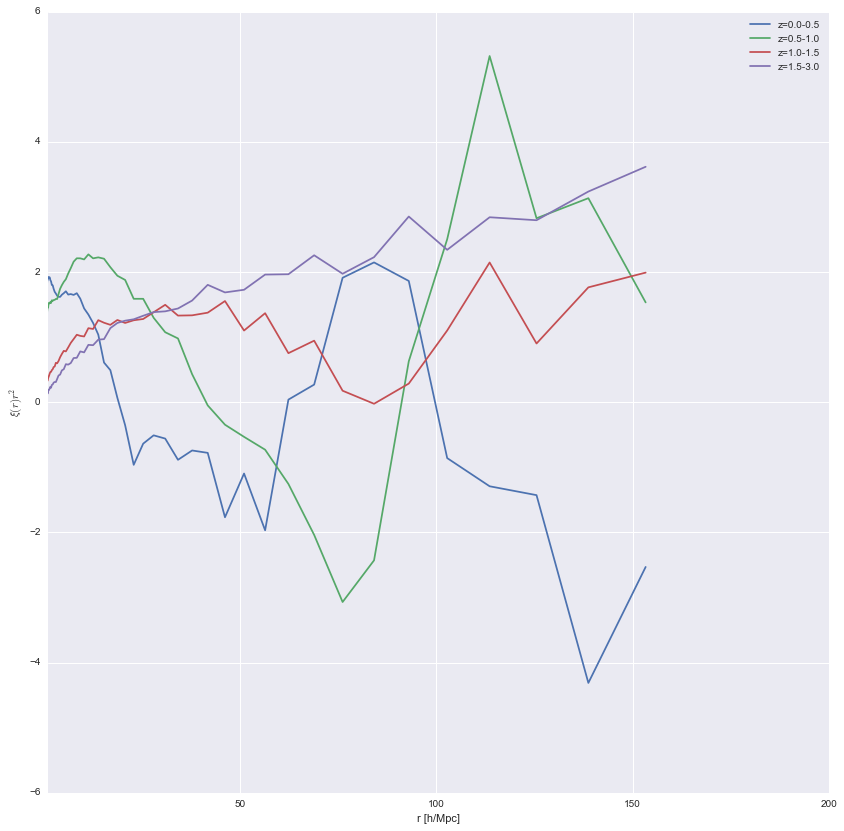

In [16]:
plt.figure(figsize=(14,14))
for zmin,zmax,rr,xi,xivar in xires:
    prr=rr*cosmo.h ## convert to Mpc/h
    plt.plot (prr,xi,label="z=%2.1f-%2.1f"%(zmin,zmax)) 
cx=logspace(log10(0.1),log10(200),10)
plt.plot (cx,cx**(-1.8),'k--',lw=2,label='power law ndx=-1.8')
plt.legend()
plt.loglog()
plt.xlim(0.1,200)
plt.xlabel("r [h/Mpc]")
plt.ylabel("$\\xi(r)$")

plt.figure(figsize=(14,14))
for zmin,zmax,rr,xi,xivar in xires:
    prr=rr*cosmo.h ## convert to Mpc/h
    plt.plot (prr,xi*prr*prr,label="z=%2.1f-%2.1f"%(zmin,zmax)) 
plt.legend()
plt.xlim(1,200)
#plt.ylim(-2,3)
plt.xlabel("r [h/Mpc]")
plt.ylabel("$\\xi(r) r^2$")